In [36]:
import gpxpy
import gpxpy.gpx
gpx = gpxpy.parse(open('data/tokyo-men.gpx','r'))
new_points = []
points = gpx.tracks[0].segments[0].points
for i, point in enumerate(points):
    if i==0:
        new_points.append(point)
    else:
        if point.latitude != points[i-1].latitude and point.longitude != points[i-1].longitude:
            new_points.append(point)
gpx.tracks[0].segments[0].points = new_points
open('data/tokyo-men.gpx','w').write(gpx.to_xml())
gpx = gpxpy.parse(open('data/tokyo-men.gpx','r'))
alts = [point.elevation for point in gpx.tracks[0].segments[0].points]

<AxesSubplot:>

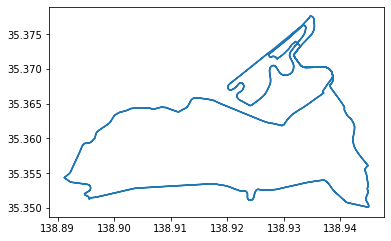

In [37]:
import geopandas as gpd
track = gpd.GeoDataFrame(columns=['name', 'geometry'], 
     geometry='geometry')
gdf = gpd.read_file('data/tokyo-men.gpx', layer='tracks')
gdf.plot()

In [38]:
gdf.head()

,name,cmt,desc,src,link1_href,link1_text,link1_type,link2_href,link2_text,link2_type,number,type,geometry
0,Tokyo 2020 Men Elite ITT,None,None,Generated by Anonymous using La Flamme Rouge t...,None,None,None,None,None,None,None,None,"MULTILINESTRING ((138.93119 35.37488, 138.9324..."


In [39]:
len(gdf.geometry[0].geoms[0].coords)

2282

In [40]:
#from shapely import geometry, ops
#singleline = ops.linemerge(gdf.geometry[0])
gdf.geometry[0]=gdf.geometry[0].geoms[0]

In [41]:
gdf.head()
print(gdf.geometry[0].coords[0])
gdf.crs

(138.93119, 35.37488)


<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

# Radius Calculation

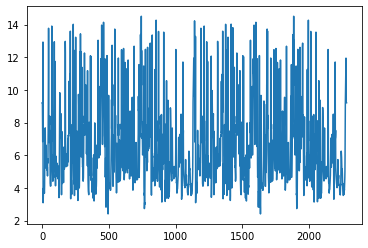

In [42]:
import pymap3d as pm
import numpy as np
import matplotlib.pyplot as plt
lat0 = gdf.geometry[0].coords[0][1]
lon0 = gdf.geometry[0].coords[0][0]
h0 = 0
lat = gdf.geometry[0].coords[1][1]
lon = gdf.geometry[0].coords[1][0]
h = 0
def get_local_coord(coord, coord0):
    lat0 = coord0[1]
    lon0 = coord0[0]
    lat = coord[1]
    lon = coord[0]
    return pm.geodetic2enu(lat, lon, 0, lat0, lon0, h0)[:2]
coords = gdf.geometry[0].coords
local_coords = [ get_local_coord(coord, coords[0]) for coord in coords]
local_coords

from scipy import optimize

x = [i[0] for i in local_coords[0:5]]
y = [i[1] for i in local_coords[0:5]]
x=[]
y=[]

def calc_R(xc, yc, x, y):
    """ calculate the distance of each 2D points from the center (xc, yc) """
    return np.sqrt((x-xc)**2 + (y-yc)**2)

def f_2(c, x, y):
    """ calculate the algebraic distance between the data points and the mean circle centered at c=(xc, yc) """
    Ri = np.sqrt((x-c[0])**2 + (y-c[1])**2)
    return Ri - Ri.mean()

def get_radius(i, local_coords, k):
    if i<k:
        return 10000
    if i+k>=len(local_coords):
        return 10000
    point_set = local_coords[i-k:i+k]
    x = [i[0] for i in point_set]
    y = [i[1] for i in point_set]
    
    center_estimate = (np.mean(x),np.mean(y))
    center, ier = optimize.leastsq(f_2, center_estimate, args=(x, y))
    #print(ier)
    Ri_2       = calc_R(*center, x, y)
    R_2        = Ri_2.mean()
    return R_2

get_radius(190, local_coords, 100)
radii = [get_radius(i, local_coords, 3) for i in range(len(local_coords))]
plt.plot(np.log(radii))

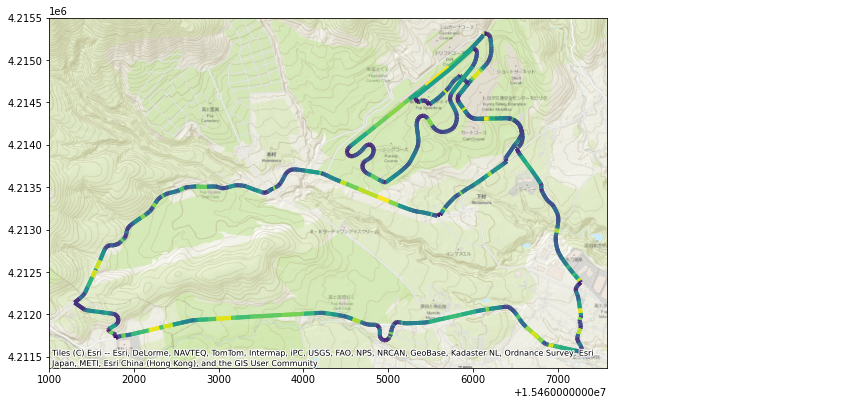

In [43]:
from shapely.geometry import Point
from shapely.geometry import LineString

import contextily as cx

def segments(curve):
    return list(map(LineString, zip(curve.coords[:-1], curve.coords[1:])))

line_segments = segments(gdf.geometry[0])
segment_radius = [(radii[i]+radii[i+1])/2 for i in range(len(radii)-1)]

tokyo_lines = gpd.GeoDataFrame(columns=['radius','geometry'],geometry='geometry')
tokyo_lines.geometry = line_segments
tokyo_lines.radius = np.log(segment_radius)

tokyo_lines.crs='epsg:4326'
tokyo_lines = tokyo_lines.to_crs(epsg=3857)
ax = tokyo_lines.plot(tokyo_lines.radius,linewidth=4,figsize=(10,10))
cx.add_basemap(ax, source=cx.providers.Esri.WorldTopoMap)
#tokyo.explore(tokyo.radius)

# Point(coords[0])
# tokyo = gpd.GeoDataFrame(columns=['radius', 'geometry'], 
#          geometry='geometry')
# points = [Point(coords[i]) for i in range(len(coords))]
# tokyo.geometry = points
# tokyo.radius = np.log(radii)
# tokyo.explore(tokyo.radius)

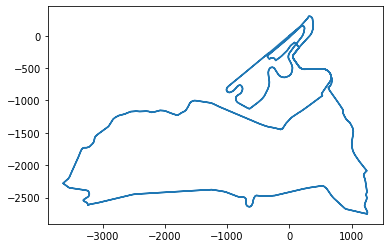

In [44]:
x = [i[0] for i in local_coords]
y = [i[1] for i in local_coords]
plt.plot(x,y)

# Distance, altitude and slope calculation

(138.93119, 35.37488)


1489.0

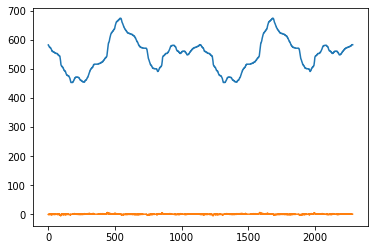

In [45]:
coord1 = gdf.geometry[0].coords[0]
print(coord1)
lat = coord1[1]
lon = coord1[0]
alt_diffs = [alts[i+1]-alts[i] for i in range(len(alts)-1)]
plt.plot(alts)
plt.plot(alt_diffs)
sum([abs(diff) for diff in alt_diffs])


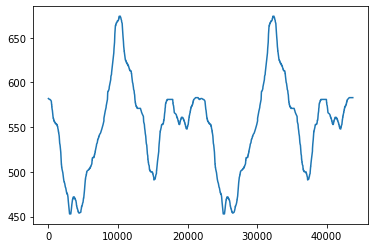

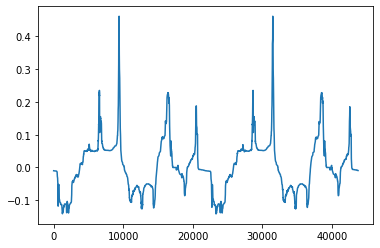

In [46]:
from haversine import haversine_vector, Unit
import numpy as np
coords_latlon = [x[::-1] for x in gdf.geometry[0].coords]
dists = haversine_vector(coords_latlon[1:],coords_latlon[:-1], Unit.METERS)
#slopes = alt_diffs/dists #too noisy!
sum(dists)
cum_dists = np.insert(np.cumsum(dists),0,0)
smoothing = 50
alt_diffs_smooth = [alts[(i+smoothing)%len(alts)]-alts[i-smoothing] for i in range(len(alts))]
dists_smooth = haversine_vector(np.roll(coords_latlon,-smoothing),np.roll(coords_latlon,smoothing), Unit.METERS)
slopes = alt_diffs_smooth/dists_smooth
#cum_dists_smooth = np.cumsum(dists_smooth)
#todo: calculate slopes CENTERED around points

plt.plot(cum_dists,alts)
plt.show()
plt.plot(cum_dists,slopes)

# Track data structures

In [47]:
import math
from math import sin, cos
g = 9.81
mu_s = 0.5
points = []

for i in range(len(alts)):
    theta = 0
    r = radii[i]
    vmax = math.sqrt(r * g * (sin(theta)+mu_s * cos(theta))/(cos(theta)-mu_s * sin(theta)))
    point = {'lon': gdf.geometry[0].coords[0], 'lat': gdf.geometry[0].coords[1],
             'alt': alts[i], 'slope': slopes[i], 'radius': radii[i], 'cumdist':cum_dists[i],
             'vmax':vmax}
    points.append(point)

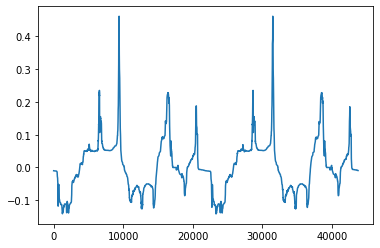

In [48]:
plt.plot([p['cumdist'] for p in points], [p['slope'] for p in points])

In [60]:
def interp(d1, d2, weight):
    return d1 * weight + d2 * (1-weight)
import math

from tqdm import tqdm
def data(x):
    #i=np.argmax([p['cumdist']>0 for p in points])
#     i=0
#     while(points[i]['cumdist']<x) and i<100000:
#         i+=1
    i = np.searchsorted(cum_dists, x)
    if i==100000: print('hmm')
    p1 = points[i-1]
    p2 = points[i]
    weight = (p2['cumdist']-x)/(p2['cumdist']-p1['cumdist'])
    slope = np.arctan(interp(p1['slope'],p2['slope'],weight))
    r = interp(p1['radius'],p2['radius'],weight)
    vmax = interp(p1['vmax'],p2['vmax'],weight)
    alt = interp(p1['alt'],p2['alt'],weight)

    
    return slope, r, vmax, alt

    

In [61]:
data_compr = 10
slope_data = []
vmax_data = []
for x in tqdm(range(math.ceil(max(cum_dists)/data_compr))):
    slope_data.append(data(x*data_compr)[0])
    vmax_data.append(data(x*data_compr)[2])
    #x_data.append([data(x)[0],data(x)[vmax]
slope_data = np.array(slope_data)
vmax_data = np.array(vmax_data)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4377/4377 [00:00<00:00, 57965.26it/s]


In [62]:
data(10000)[0]

0.007836313203253408

# Track Discretization

In [175]:
from scipy.signal import find_peaks
#plt.plot(alts)
peaks = find_peaks(np.array(alts),height=10)[0]
troughs = find_peaks(-np.array(alts)+max(alts),height=10)[0]



In [176]:
vmax = [p['vmax'] for p in points]
# convert vmax values to be based on x
max_dist = math.ceil(max(cum_dists))
vmax = np.zeros(max_dist)
print('hmm')
for i in range(max_dist):
    vmax[i] = data(i)[2]
print('hmm')
vmax_seps = find_peaks(-np.array(vmax)+max(vmax),height=10,distance=200)
heights = -vmax_seps[1]['peak_heights']+max(vmax)
cutoff = heights < 20

curveseps = vmax_seps[0]
curveseps = curveseps[cutoff]
brakeseps = np.array(curveseps)-100

print('hmm')

#plt.plot(cum_dists,vmax)


hmm
hmm
hmm


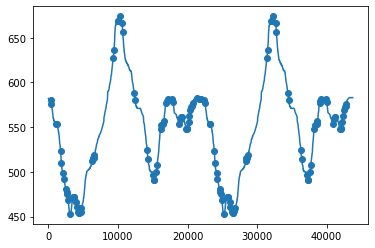

In [168]:
seps = np.append(peaks,troughs)
sep_x = [cum_dists[sep] for sep in seps]
sep_x = np.append(sep_x,[curveseps, brakeseps])
sep_alt = [data(x)[3] for x in sep_x]

#plt.scatter(curveseps,np.zeros(len(seps)))
#plt.scatter(brakeseps,np.zeros(len(seps)))
plt.scatter(sep_x, sep_alt)
plt.plot([p['cumdist'] for p in points], [p['alt'] for p in points])

# DIFF EQ

In [65]:
def P(x):
    return 400
def T(P):
    return 1/P * 1000

In [66]:
slope_data[100]

-0.11189919393287641

In [83]:
from scipy.integrate import odeint
import numpy as np
import matplotlib.pyplot as plt

from math import sin, cos
v0 = 0.001
e0 = 1
x_max = max(cum_dists)
print(x_max)
m = 70
x0 = 0

Cd = 0.05
rho = 1.29 # should be function of air density
A = 0.4
g = 9.81
mu = 0.002

n = 1000

S0 = np.array([np.random.randint(1,50,n), np.random.randint(1,20,n), np.repeat(e0,n)]).flatten()
acc = []

def f(S, t):
    
    
    #x, v, e = S
    x = S[:n]
    
    
    #print(x[1])
    v = S[n:(2*n)]
    e=S[(2*n):]
    
    #print(t,v)
    #x[x>x_max]=x_max
    idx = np.floor(x/data_compr).astype(int)
    slope = slope_data[idx]
    vmax = vmax_data[idx]
    #v[v>vmax] = vmax
    #x_datas = #x_data[[np.random.randint(0,4)]]#x_data[np.floor(x).astype(int)]
    #print(data)
#     slope = x_datas[:,0]
#     vmax = x_datas[:,2]
    #slope, r, vmax, alt = 0, 0, 100, 0#data(x[0])
    
#     if(v>vmax):
#         print(v)

    
    a = (P(x)/v - Cd*rho*A*(v**2)/2 - m*g*(np.sin(slope)+mu*np.cos(slope)))/m
    acc.append(a[0])
    #print(x[0])
    #a = (P(x)/v)/m
    #print(a,v)
    dxdt = v
    dvdt = a
    
    dedt = np.repeat(-1/T(P(x)),n)
    
    return np.array([dxdt, dvdt, dedt]).flatten()

t_span = np.linspace(0, 5000, 40000)
solution = odeint(f, S0, t_span)



43766.00434474005


/home/aozerov/projects/optimal-cycling/lib/python3.8/site-packages/scipy/integrate/_odepack_py.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


In [174]:
def dxdt(v):
    return v
def dvdt(a):
    return a
def dedt(x):
    return np.repeat(-1/T(P(x)),len(x))

def step(x, v, e, i, h, P):
    x[x>x_max]=x_max
    idx = np.floor(x/data_compr).astype(int)
    slope = slope_data[idx]
    vmax = vmax_data[idx]
    v = (v>vmax) * vmax + (v<=vmax) * v
    
    a = (P(x)/v - Cd*rho*A*(v**2)/2 - m*g*(np.sin(slope)+mu*np.cos(slope)))/m

    v = v + a * h
    x = x + dxdt(v) * h
    e = e - dedt(x) * h

#         x_sol[i,:] = x
#         v_sol[i,:] = v
#         e_sol[i,:] = e
    return x, v, e


def simulate(n, h, P):
    
    v0 = np.zeros(n)+0.01
    x0 = np.zeros(n)
    e0 = np.zeros(n)+1
    
#     t_max = 6000
#     iterations = math.ceil(t_max/h)
#     t_span = np.linspace(0,t_max, iterations)

    x = np.zeros(n)
    v = np.zeros(n)+0.1
    e = np.zeros(n)+1
    #x_sol = np.zeros((iterations, n))
    #v_sol = np.zeros((iterations, n))
    #e_sol = np.zeros((iterations, n))
    i = 0
    while(max(x)< x_max):
        x, v, e = step(x, v, e, i, h, P)
        if i%2000 == 0: print(max(x))
        i += 1
    return i * h

P = np.random.rand(n_segments, n)*100 + 300
simulate(1000, 0.5, None)


TypeError: 'NoneType' object is not callable

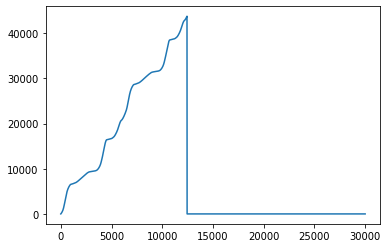

In [155]:
plt.plot(x_sol[:,2])

(0.0, 200.0)

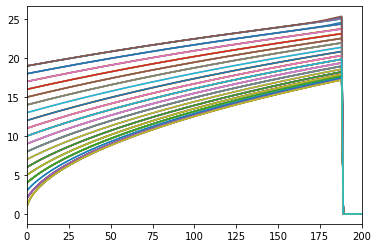

In [82]:
for i in range(0,100): plt.plot(solution[:, n+i])
plt.xlim(0, 200)

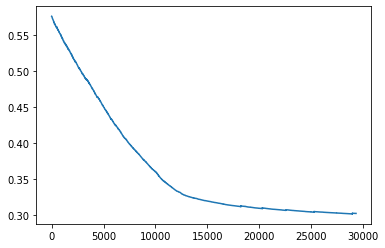

In [79]:
plt.plot(acc)

In [273]:
data(5500)

(0.05166008075936312, 2393.997606564281, 105.30698527255755, 499.4503808625186)

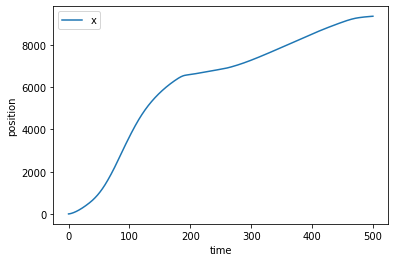

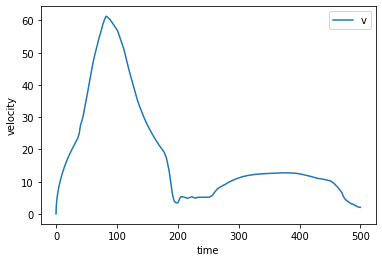

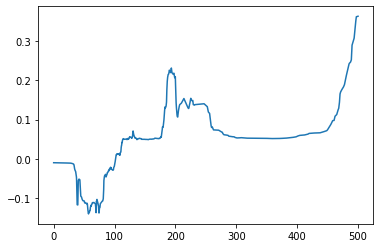

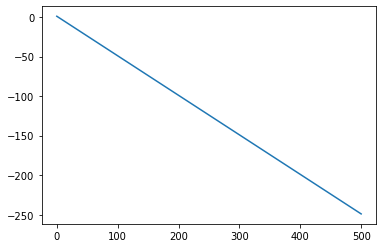

In [150]:
x = solution[:, 0]
v = solution[:, 1]
e = solution[:, 2]

slope = [data(x_pos)[0] for x_pos in x]

plt.plot(t_span, x, label='x')
#plt.plot(t_span, solution[:, 1], label='v')
plt.legend()
plt.xlabel('time')
plt.ylabel('position')
plt.show()
plt.plot(t_span, v, label='v')
#plt.plot(t_span, solution[:, 1], label='v')
plt.legend()
plt.xlabel('time')
plt.ylabel('velocity')
plt.show()
plt.plot(t_span, slope)
plt.show()

plt.plot(t_span, e)

In [ ]:
plt.plot([p['cumdist'] for p in points], [p['slope'] for p in points])

# Power Curve Calculation

In [169]:
x = [5, 1*60, 5*60, 60*60]
y = [24.04, 11.5, 7.6, 6.4]

(0.0, 30.0)

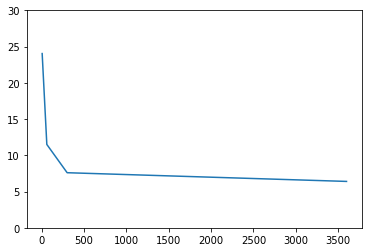

In [170]:
plt.plot(x,y)
plt.ylim(0,30)